# Use LSTM for Move Review Classification

Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Functions for tokenization and padding

In [3]:
def tokenize(x_train, x_val):
    word_list = []

    # Get a list of all tokens
    for sent in x_train:
        for word in sent.split(): # Already lowercased and punctuation split off in dataset
            word_list.append(word)

    for i in range(1000): # Make sure unknown token is common
        word_list.append('<unk>') # Add an unknown token
    # Get corpus of all words in training data
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train, final_list_val = [], []
    for sent in x_train:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_train.append(sent_list)

    for sent in x_val:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_val.append(sent_list)

    # 0 pad to have equal length
    #max_len = max([len(i) for i in final_list_train])
    max_len = 500

    for i in range(len(final_list_train)):
        if len(final_list_train[i]) < max_len:
            final_list_train[i] = final_list_train[i] + [0] * (max_len - len(final_list_train[i]))
        elif len(final_list_train[i]) == max_len:
            continue
        else:
            final_list_train[i] = final_list_train[i][:max_len]

    for i in range(len(final_list_val)):
        if len(final_list_val[i]) < max_len:
            final_list_val[i] = final_list_val[i] + [0] * (max_len - len(final_list_val[i]))
        elif len(final_list_val[i]) == max_len:
            continue
        else:
            final_list_val[i] = final_list_val[i][:max_len]


    print(len(final_list_train[0]),len(final_list_train[1]))
    return np.array(final_list_train), np.array(final_list_val), onehot_dict

## Read in data

In [4]:
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

# See if changing 5 to negative gives better threshold
train.loc[train['Rating'] < 6,'Polarity'] = 0
val.loc[val['Rating'] < 6,'Polarity'] = 0
test.loc[test['Rating'] < 6,'Polarity'] = 0

display(train)

,Review,Rating,ID,Class3,Class4,Author,PolarityScore,Polarity
0,carried away is an incredible film being opene...,8,5986,2,3,Steve+Rhodes,0.165410,1
1,ernest : the one-joke concept that refuses to ...,1,2240,0,0,James+Berardinelli,-0.044428,0
2,"worse still , the only thing about live and le...",5,4553,1,1,James+Berardinelli,0.016052,0
3,ron shelton appears to understand two things b...,9,5831,2,3,Scott+Renshaw,0.210099,1
4,place your foot on the accelerator . watch the...,9,2626,2,3,James+Berardinelli,0.169854,1
...,...,...,...,...,...,...,...,...
3499,it is reported to be a remake of no man of her...,4,5758,0,1,Steve+Rhodes,0.057292,0
3500,"writer and director james l . brooks , who has...",8,10297,2,3,Steve+Rhodes,0.258572,1
3501,"gosh , aren't fart jokes funny ? and if you've...",3,25495,0,0,Steve+Rhodes,0.088385,0
3502,screenplay : jim mcglynn . mpaa rating : r ( p...,7,7512,2,2,Scott+Renshaw,0.264333,1


Insert start tokens

In [5]:
for i in range(train.shape[0]):
    review = train['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    train['Review'].iloc[i] = review

for i in range(val.shape[0]):
    review = val['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    val['Review'].iloc[i] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  val['Review'].iloc[i] = review
<ipython-input-5-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-5-a6f968306030>:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are settin

Tokenize

In [6]:
x_train, x_val, vocab = tokenize(train['Review'],val['Review'])

500 500


In [7]:
x_train.shape,x_val.shape

((3504, 500), (1001, 500))

In [8]:
print(x_train[0])

[   2 3129  304    9   26 1795   17  131 3444 1304  223    1 2930 2176
   31   42  843  186  222  592    4    2    1   17   36  106 1160  275
   31 2207  165    7 2243  165   12   21  156 1222    5  830 4043    3
    7    1  466    5    1  178  246  161  275   14  137    4    2   54
    5   47   11    9    6 3445   17  134  598    6  165   24    4    2
   41 2010  165  572    4    2   18 4044    3  360   29  169    3   16
    9    1  165   51   13  279 1796    4    2  137    3  587   11    9
    3   19   22  100  169   50    4    2   37   36    1   87  179    8
  712  304   45  111    6  165    5  805    3   19 1020    1  165    8
 1078  304   13   35   44    6  101  177    4    2   45   49    1   51
    9    6 1926    5    1  165    7    1  746 1235    4    2    1  924
    5  165   14    1  609    9  442    4    2   33  164    9 1686    5
 1647 2083   10   24    5   33  165  512  564    4    2 1954    3    1
   77  250 2243  165    3   55 1412  107    6   87  132  174  165  165
  165 

In [9]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


## Create data loaders

In [10]:
x_train.shape, train['Rating'].values.squeeze().shape

((3504, 500), (3504,))

In [11]:
# create Tensor datasets
train_data1 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Rating'].values))
val_data1 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Rating'].values))

train_data2 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Polarity'].values))
val_data2 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Polarity'].values))

batch_size = 128

# dataloaders
train_loader1 = DataLoader(train_data1, shuffle=True, batch_size=batch_size)
val_loader1 = DataLoader(val_data1, shuffle=False, batch_size=batch_size)

train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=batch_size)
val_loader2 = DataLoader(val_data2, shuffle=False, batch_size=batch_size)

## Create Model

In [12]:
class SentimentLSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim1, output_dim2):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        self.fc11 = torch.nn.Linear(hidden_dim, 10)
        self.fc21 = torch.nn.Linear(hidden_dim, 10)

        self.fc12 = torch.nn.Linear(10, output_dim1)
        self.fc22 = torch.nn.Linear(10, output_dim2)
        self.relu = nn.ReLU()


    def forward(self, text, task_id):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]
        hidden.squeeze_(0)

        # hidden dim: [batch size, hidden dim]

        hidden = self.dropout1(hidden)

        if task_id == 0:
            output = self.fc11(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc12(output)

            return output

        if task_id == 1:
            output = self.fc21(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc22(output)

            return output

In [13]:
torch.manual_seed(100)
model = SentimentLSTM(input_dim = len(vocab)+1,
                      embedding_dim = 300,
                      hidden_dim = 64, # 64 best so far
                      output_dim1 = 11,
                      output_dim2 = 2
)

# Use batch size 128

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

Use this if bidirectional

## Train Model

In [14]:
train_loss1 = []
val_loss1 = []
train_acc1 = []
val_acc1 = []
train_loss2 = []
val_loss2 = []
train_acc2 = []
val_acc2 = []

n_epochs = 200

# Train the model
for epoch in tqdm(range(n_epochs)):
    model.train()

    correct_train1 = 0
    correct_val1 = 0

    correct_train2 = 0
    correct_val2 = 0

    total_train_samples = 0
    total_val_samples = 0

    epoch_loss_train1 = 0
    epoch_loss_train2 = 0
    epoch_loss_val1 = 0
    epoch_loss_val2 = 0

    # Train the model
    for (text1, labels1), (text2, labels2) in zip(train_loader1, train_loader2):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)

        optimizer.zero_grad()

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        loss1 = criterion(pred1, labels1)

        # Predict second task
        pred2 = model(text2, task_id = 1)
        loss2 = criterion(pred2, labels2)

        # Make auxiliary task loss half to put more focus on main task
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        epoch_loss_train1 += loss1.item()
        epoch_loss_train2 += loss2.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)

        correct_train1 += (pred1 == labels1).sum().item()
        correct_train2 += (pred2 == labels2).sum().item()
        total_train_samples += labels1.size(0)

        del text1, labels1, text2, labels2, pred1, pred2, loss, loss1, loss2

    train_loss1.append(epoch_loss_train1)
    train_accuracy1 = (correct_train1 / total_train_samples) * 100
    train_acc1.append(train_accuracy1)

    train_loss2.append(epoch_loss_train2)
    train_accuracy2 = (correct_train2 / total_train_samples) * 100
    train_acc2.append(train_accuracy2)

    # Validate
    with torch.no_grad():
        model.eval()

        for (text1, labels1), (text2, labels2) in zip(val_loader1, val_loader2):

            text1, labels1 = text1.T.to(device), labels1.to(device)
            text2, labels2 = text2.T.to(device), labels2.to(device)

            # Predict scale rating
            pred1 = model(text1, task_id = 0)
            loss1 = criterion(pred1, labels1)

            # Predict second task
            pred2 = model(text2, task_id = 1)
            loss2 = criterion(pred2, labels2)

            epoch_loss_val1 += loss1.item()
            epoch_loss_val2 += loss2.item()

            # Calculate accuracy for current batch
            pred1 = pred1.argmax(dim=1)
            pred2 = pred2.argmax(dim=1)

            correct_val1 += (pred1 == labels1).sum().item()
            correct_val2 += (pred2 == labels2).sum().item()
            total_val_samples += labels1.size(0)

            del text1, labels1, text2, labels2, pred1, pred2, loss1, loss2

    val_loss1.append(epoch_loss_val1)
    val_accuracy1 = (correct_val1 / total_val_samples) * 100
    val_acc1.append(val_accuracy1)

    val_loss2.append(epoch_loss_val2)
    val_accuracy2 = (correct_val2 / total_val_samples) * 100
    val_acc2.append(val_accuracy2)

    print(f"Epoch {epoch+1}, \
           Train Scale Rating Accuracy: {round(train_accuracy1,5)}, \
           Validation Scale Rating Accuracy: {round(val_accuracy1,5)}, \
           Train Polarity Accuracy: {round(train_accuracy2,5)}, \
           Validation Polarity Accuracy: {round(val_accuracy2,5)}")

  0%|          | 1/200 [00:01<06:24,  1.93s/it]

Epoch 1,            Train Scale Rating Accuracy: 4.7089,            Validation Scale Rating Accuracy: 8.99101,            Train Polarity Accuracy: 58.13356,            Validation Polarity Accuracy: 58.64136


  1%|          | 2/200 [00:02<04:12,  1.28s/it]

Epoch 2,            Train Scale Rating Accuracy: 10.35959,            Validation Scale Rating Accuracy: 9.59041,            Train Polarity Accuracy: 57.16324,            Validation Polarity Accuracy: 58.64136


  2%|▏         | 3/200 [00:03<03:30,  1.07s/it]

Epoch 3,            Train Scale Rating Accuracy: 10.50228,            Validation Scale Rating Accuracy: 15.18482,            Train Polarity Accuracy: 57.50571,            Validation Polarity Accuracy: 58.64136


  2%|▏         | 4/200 [00:04<03:10,  1.03it/s]

Epoch 4,            Train Scale Rating Accuracy: 12.15753,            Validation Scale Rating Accuracy: 15.68432,            Train Polarity Accuracy: 57.6484,            Validation Polarity Accuracy: 58.64136


  2%|▎         | 5/200 [00:05<02:58,  1.09it/s]

Epoch 5,            Train Scale Rating Accuracy: 12.41438,            Validation Scale Rating Accuracy: 15.98402,            Train Polarity Accuracy: 57.93379,            Validation Polarity Accuracy: 58.64136


  3%|▎         | 6/200 [00:06<02:51,  1.13it/s]

Epoch 6,            Train Scale Rating Accuracy: 12.41438,            Validation Scale Rating Accuracy: 16.88312,            Train Polarity Accuracy: 57.53425,            Validation Polarity Accuracy: 58.64136


  4%|▎         | 7/200 [00:06<02:46,  1.16it/s]

Epoch 7,            Train Scale Rating Accuracy: 12.58562,            Validation Scale Rating Accuracy: 16.98302,            Train Polarity Accuracy: 57.6484,            Validation Polarity Accuracy: 58.64136


  4%|▍         | 8/200 [00:07<02:43,  1.18it/s]

Epoch 8,            Train Scale Rating Accuracy: 14.75457,            Validation Scale Rating Accuracy: 17.38262,            Train Polarity Accuracy: 57.6484,            Validation Polarity Accuracy: 58.64136


  4%|▍         | 9/200 [00:08<02:41,  1.18it/s]

Epoch 9,            Train Scale Rating Accuracy: 14.95434,            Validation Scale Rating Accuracy: 18.18182,            Train Polarity Accuracy: 58.01941,            Validation Polarity Accuracy: 58.64136


  5%|▌         | 10/200 [00:09<02:41,  1.18it/s]

Epoch 10,            Train Scale Rating Accuracy: 15.12557,            Validation Scale Rating Accuracy: 18.68132,            Train Polarity Accuracy: 58.73288,            Validation Polarity Accuracy: 58.64136


  6%|▌         | 11/200 [00:10<02:40,  1.18it/s]

Epoch 11,            Train Scale Rating Accuracy: 15.03995,            Validation Scale Rating Accuracy: 18.98102,            Train Polarity Accuracy: 58.01941,            Validation Polarity Accuracy: 58.64136


  6%|▌         | 12/200 [00:11<02:39,  1.18it/s]

Epoch 12,            Train Scale Rating Accuracy: 15.69635,            Validation Scale Rating Accuracy: 19.18082,            Train Polarity Accuracy: 58.21918,            Validation Polarity Accuracy: 58.64136


  6%|▋         | 13/200 [00:11<02:37,  1.19it/s]

Epoch 13,            Train Scale Rating Accuracy: 16.12443,            Validation Scale Rating Accuracy: 19.38062,            Train Polarity Accuracy: 58.36187,            Validation Polarity Accuracy: 58.64136


  7%|▋         | 14/200 [00:12<02:35,  1.20it/s]

Epoch 14,            Train Scale Rating Accuracy: 15.8105,            Validation Scale Rating Accuracy: 19.28072,            Train Polarity Accuracy: 58.01941,            Validation Polarity Accuracy: 58.64136


  8%|▊         | 15/200 [00:13<02:34,  1.20it/s]

Epoch 15,            Train Scale Rating Accuracy: 16.72374,            Validation Scale Rating Accuracy: 19.48052,            Train Polarity Accuracy: 58.27626,            Validation Polarity Accuracy: 58.64136


  8%|▊         | 16/200 [00:14<02:33,  1.20it/s]

Epoch 16,            Train Scale Rating Accuracy: 17.18037,            Validation Scale Rating Accuracy: 19.38062,            Train Polarity Accuracy: 57.96233,            Validation Polarity Accuracy: 58.64136


  8%|▊         | 17/200 [00:15<02:33,  1.20it/s]

Epoch 17,            Train Scale Rating Accuracy: 17.18037,            Validation Scale Rating Accuracy: 19.68032,            Train Polarity Accuracy: 58.21918,            Validation Polarity Accuracy: 58.64136


  9%|▉         | 18/200 [00:16<02:32,  1.20it/s]

Epoch 18,            Train Scale Rating Accuracy: 18.379,            Validation Scale Rating Accuracy: 19.88012,            Train Polarity Accuracy: 58.10502,            Validation Polarity Accuracy: 58.64136


 10%|▉         | 19/200 [00:16<02:32,  1.19it/s]

Epoch 19,            Train Scale Rating Accuracy: 18.49315,            Validation Scale Rating Accuracy: 19.58042,            Train Polarity Accuracy: 58.10502,            Validation Polarity Accuracy: 58.64136


 10%|█         | 20/200 [00:17<02:32,  1.18it/s]

Epoch 20,            Train Scale Rating Accuracy: 18.00799,            Validation Scale Rating Accuracy: 19.88012,            Train Polarity Accuracy: 58.01941,            Validation Polarity Accuracy: 58.64136


 10%|█         | 21/200 [00:18<02:32,  1.18it/s]

Epoch 21,            Train Scale Rating Accuracy: 17.97945,            Validation Scale Rating Accuracy: 19.88012,            Train Polarity Accuracy: 58.33333,            Validation Polarity Accuracy: 58.64136


 11%|█         | 22/200 [00:19<02:31,  1.18it/s]

Epoch 22,            Train Scale Rating Accuracy: 17.92237,            Validation Scale Rating Accuracy: 19.78022,            Train Polarity Accuracy: 58.1621,            Validation Polarity Accuracy: 58.64136


 12%|█▏        | 23/200 [00:20<02:31,  1.17it/s]

Epoch 23,            Train Scale Rating Accuracy: 18.12215,            Validation Scale Rating Accuracy: 19.58042,            Train Polarity Accuracy: 57.93379,            Validation Polarity Accuracy: 58.64136


 12%|█▏        | 24/200 [00:21<02:31,  1.16it/s]

Epoch 24,            Train Scale Rating Accuracy: 18.77854,            Validation Scale Rating Accuracy: 19.48052,            Train Polarity Accuracy: 58.13356,            Validation Polarity Accuracy: 58.64136


 12%|█▎        | 25/200 [00:22<02:32,  1.15it/s]

Epoch 25,            Train Scale Rating Accuracy: 18.94977,            Validation Scale Rating Accuracy: 19.08092,            Train Polarity Accuracy: 58.1621,            Validation Polarity Accuracy: 58.64136


 13%|█▎        | 26/200 [00:23<02:32,  1.14it/s]

Epoch 26,            Train Scale Rating Accuracy: 18.66438,            Validation Scale Rating Accuracy: 18.78122,            Train Polarity Accuracy: 58.13356,            Validation Polarity Accuracy: 58.64136


 14%|█▎        | 27/200 [00:23<02:32,  1.13it/s]

Epoch 27,            Train Scale Rating Accuracy: 18.379,            Validation Scale Rating Accuracy: 18.78122,            Train Polarity Accuracy: 58.01941,            Validation Polarity Accuracy: 58.64136


 14%|█▍        | 28/200 [00:24<02:31,  1.14it/s]

Epoch 28,            Train Scale Rating Accuracy: 18.63584,            Validation Scale Rating Accuracy: 18.88112,            Train Polarity Accuracy: 58.30479,            Validation Polarity Accuracy: 58.64136


 14%|█▍        | 29/200 [00:25<02:30,  1.14it/s]

Epoch 29,            Train Scale Rating Accuracy: 19.2637,            Validation Scale Rating Accuracy: 19.28072,            Train Polarity Accuracy: 58.30479,            Validation Polarity Accuracy: 58.64136


 15%|█▌        | 30/200 [00:26<02:28,  1.14it/s]

Epoch 30,            Train Scale Rating Accuracy: 19.6347,            Validation Scale Rating Accuracy: 19.78022,            Train Polarity Accuracy: 58.19064,            Validation Polarity Accuracy: 58.64136


 16%|█▌        | 31/200 [00:27<02:34,  1.09it/s]

Epoch 31,            Train Scale Rating Accuracy: 19.14954,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 58.19064,            Validation Polarity Accuracy: 58.64136


 16%|█▌        | 32/200 [00:28<02:31,  1.11it/s]

Epoch 32,            Train Scale Rating Accuracy: 19.2637,            Validation Scale Rating Accuracy: 20.47952,            Train Polarity Accuracy: 58.13356,            Validation Polarity Accuracy: 58.64136


 16%|█▋        | 33/200 [00:29<02:29,  1.12it/s]

Epoch 33,            Train Scale Rating Accuracy: 20.17694,            Validation Scale Rating Accuracy: 20.57942,            Train Polarity Accuracy: 58.21918,            Validation Polarity Accuracy: 58.64136


 17%|█▋        | 34/200 [00:30<02:27,  1.13it/s]

Epoch 34,            Train Scale Rating Accuracy: 19.20662,            Validation Scale Rating Accuracy: 19.48052,            Train Polarity Accuracy: 58.04795,            Validation Polarity Accuracy: 58.64136


 18%|█▊        | 35/200 [00:31<02:26,  1.13it/s]

Epoch 35,            Train Scale Rating Accuracy: 20.1484,            Validation Scale Rating Accuracy: 20.17982,            Train Polarity Accuracy: 58.44749,            Validation Polarity Accuracy: 58.64136


 18%|█▊        | 36/200 [00:31<02:25,  1.13it/s]

Epoch 36,            Train Scale Rating Accuracy: 20.2911,            Validation Scale Rating Accuracy: 20.57942,            Train Polarity Accuracy: 58.41895,            Validation Polarity Accuracy: 58.64136


 18%|█▊        | 37/200 [00:32<02:24,  1.13it/s]

Epoch 37,            Train Scale Rating Accuracy: 20.71918,            Validation Scale Rating Accuracy: 20.77922,            Train Polarity Accuracy: 58.90411,            Validation Polarity Accuracy: 58.54146


 19%|█▉        | 38/200 [00:33<02:24,  1.12it/s]

Epoch 38,            Train Scale Rating Accuracy: 19.72032,            Validation Scale Rating Accuracy: 20.47952,            Train Polarity Accuracy: 58.70434,            Validation Polarity Accuracy: 58.34166


 20%|█▉        | 39/200 [00:34<02:23,  1.12it/s]

Epoch 39,            Train Scale Rating Accuracy: 20.2911,            Validation Scale Rating Accuracy: 21.17882,            Train Polarity Accuracy: 58.47603,            Validation Polarity Accuracy: 58.34166


 20%|██        | 40/200 [00:35<02:23,  1.11it/s]

Epoch 40,            Train Scale Rating Accuracy: 20.60502,            Validation Scale Rating Accuracy: 20.07992,            Train Polarity Accuracy: 58.27626,            Validation Polarity Accuracy: 58.34166


 20%|██        | 41/200 [00:36<02:23,  1.11it/s]

Epoch 41,            Train Scale Rating Accuracy: 19.29224,            Validation Scale Rating Accuracy: 20.07992,            Train Polarity Accuracy: 59.01826,            Validation Polarity Accuracy: 58.34166


 21%|██        | 42/200 [00:37<02:22,  1.11it/s]

Epoch 42,            Train Scale Rating Accuracy: 20.71918,            Validation Scale Rating Accuracy: 20.57942,            Train Polarity Accuracy: 58.87557,            Validation Polarity Accuracy: 58.44156


 22%|██▏       | 43/200 [00:38<02:21,  1.11it/s]

Epoch 43,            Train Scale Rating Accuracy: 20.69064,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 58.36187,            Validation Polarity Accuracy: 58.34166


 22%|██▏       | 44/200 [00:39<02:20,  1.11it/s]

Epoch 44,            Train Scale Rating Accuracy: 20.46233,            Validation Scale Rating Accuracy: 19.88012,            Train Polarity Accuracy: 60.21689,            Validation Polarity Accuracy: 58.24176


 22%|██▎       | 45/200 [00:40<02:20,  1.11it/s]

Epoch 45,            Train Scale Rating Accuracy: 21.48973,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 59.5605,            Validation Polarity Accuracy: 58.14186


 23%|██▎       | 46/200 [00:40<02:19,  1.11it/s]

Epoch 46,            Train Scale Rating Accuracy: 21.06164,            Validation Scale Rating Accuracy: 21.17882,            Train Polarity Accuracy: 60.33105,            Validation Polarity Accuracy: 58.24176


 24%|██▎       | 47/200 [00:41<02:17,  1.11it/s]

Epoch 47,            Train Scale Rating Accuracy: 21.66096,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 60.87329,            Validation Polarity Accuracy: 58.04196


 24%|██▍       | 48/200 [00:42<02:16,  1.12it/s]

Epoch 48,            Train Scale Rating Accuracy: 21.48973,            Validation Scale Rating Accuracy: 20.17982,            Train Polarity Accuracy: 61.21575,            Validation Polarity Accuracy: 57.84216


 24%|██▍       | 49/200 [00:43<02:16,  1.11it/s]

Epoch 49,            Train Scale Rating Accuracy: 21.94635,            Validation Scale Rating Accuracy: 18.38162,            Train Polarity Accuracy: 62.55708,            Validation Polarity Accuracy: 57.54246


 25%|██▌       | 50/200 [00:44<02:14,  1.11it/s]

Epoch 50,            Train Scale Rating Accuracy: 22.28881,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 63.12785,            Validation Polarity Accuracy: 59.54046


 26%|██▌       | 51/200 [00:45<02:14,  1.11it/s]

Epoch 51,            Train Scale Rating Accuracy: 23.0879,            Validation Scale Rating Accuracy: 19.68032,            Train Polarity Accuracy: 64.55479,            Validation Polarity Accuracy: 57.44256


 26%|██▌       | 52/200 [00:46<02:13,  1.11it/s]

Epoch 52,            Train Scale Rating Accuracy: 22.63128,            Validation Scale Rating Accuracy: 21.87812,            Train Polarity Accuracy: 64.84018,            Validation Polarity Accuracy: 59.14086


 26%|██▋       | 53/200 [00:47<02:13,  1.10it/s]

Epoch 53,            Train Scale Rating Accuracy: 23.51598,            Validation Scale Rating Accuracy: 20.27972,            Train Polarity Accuracy: 66.60959,            Validation Polarity Accuracy: 60.13986


 27%|██▋       | 54/200 [00:48<02:13,  1.10it/s]

Epoch 54,            Train Scale Rating Accuracy: 24.05822,            Validation Scale Rating Accuracy: 19.78022,            Train Polarity Accuracy: 68.379,            Validation Polarity Accuracy: 59.14086


 28%|██▊       | 55/200 [00:49<02:12,  1.09it/s]

Epoch 55,            Train Scale Rating Accuracy: 24.14384,            Validation Scale Rating Accuracy: 20.47952,            Train Polarity Accuracy: 69.46347,            Validation Polarity Accuracy: 58.94106


 28%|██▊       | 56/200 [00:50<02:11,  1.09it/s]

Epoch 56,            Train Scale Rating Accuracy: 24.57192,            Validation Scale Rating Accuracy: 20.67932,            Train Polarity Accuracy: 70.86187,            Validation Polarity Accuracy: 59.34066


 28%|██▊       | 57/200 [00:50<02:11,  1.09it/s]

Epoch 57,            Train Scale Rating Accuracy: 24.4863,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 71.88927,            Validation Polarity Accuracy: 61.13886


 29%|██▉       | 58/200 [00:51<02:10,  1.09it/s]

Epoch 58,            Train Scale Rating Accuracy: 24.08676,            Validation Scale Rating Accuracy: 21.07892,            Train Polarity Accuracy: 73.23059,            Validation Polarity Accuracy: 61.73826


 30%|██▉       | 59/200 [00:52<02:09,  1.09it/s]

Epoch 59,            Train Scale Rating Accuracy: 25.05708,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 74.54338,            Validation Polarity Accuracy: 62.03796


 30%|███       | 60/200 [00:53<02:08,  1.09it/s]

Epoch 60,            Train Scale Rating Accuracy: 25.59932,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 75.02854,            Validation Polarity Accuracy: 61.93806


 30%|███       | 61/200 [00:54<02:07,  1.09it/s]

Epoch 61,            Train Scale Rating Accuracy: 26.34132,            Validation Scale Rating Accuracy: 20.67932,            Train Polarity Accuracy: 75.59932,            Validation Polarity Accuracy: 60.13986


 31%|███       | 62/200 [00:55<02:06,  1.09it/s]

Epoch 62,            Train Scale Rating Accuracy: 27.16895,            Validation Scale Rating Accuracy: 21.17882,            Train Polarity Accuracy: 76.5411,            Validation Polarity Accuracy: 61.83816


 32%|███▏      | 63/200 [00:56<02:05,  1.09it/s]

Epoch 63,            Train Scale Rating Accuracy: 26.34132,            Validation Scale Rating Accuracy: 21.27872,            Train Polarity Accuracy: 77.68265,            Validation Polarity Accuracy: 61.63836


 32%|███▏      | 64/200 [00:57<02:04,  1.09it/s]

Epoch 64,            Train Scale Rating Accuracy: 26.79795,            Validation Scale Rating Accuracy: 20.67932,            Train Polarity Accuracy: 79.3379,            Validation Polarity Accuracy: 62.03796


 32%|███▎      | 65/200 [00:58<02:03,  1.10it/s]

Epoch 65,            Train Scale Rating Accuracy: 26.45548,            Validation Scale Rating Accuracy: 21.07892,            Train Polarity Accuracy: 79.59475,            Validation Polarity Accuracy: 61.83816


 33%|███▎      | 66/200 [00:59<02:02,  1.09it/s]

Epoch 66,            Train Scale Rating Accuracy: 27.62557,            Validation Scale Rating Accuracy: 20.37962,            Train Polarity Accuracy: 81.59247,            Validation Polarity Accuracy: 62.23776


 34%|███▎      | 67/200 [01:00<02:02,  1.09it/s]

Epoch 67,            Train Scale Rating Accuracy: 27.91096,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 82.33447,            Validation Polarity Accuracy: 62.43756


 34%|███▍      | 68/200 [01:01<02:01,  1.09it/s]

Epoch 68,            Train Scale Rating Accuracy: 25.77055,            Validation Scale Rating Accuracy: 20.97902,            Train Polarity Accuracy: 79.90868,            Validation Polarity Accuracy: 62.03796


 34%|███▍      | 69/200 [01:01<02:00,  1.09it/s]

Epoch 69,            Train Scale Rating Accuracy: 27.22603,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 82.1347,            Validation Polarity Accuracy: 60.93906


 35%|███▌      | 70/200 [01:02<02:00,  1.08it/s]

Epoch 70,            Train Scale Rating Accuracy: 27.91096,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 81.79224,            Validation Polarity Accuracy: 65.13487


 36%|███▌      | 71/200 [01:03<01:58,  1.09it/s]

Epoch 71,            Train Scale Rating Accuracy: 28.85274,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 83.96119,            Validation Polarity Accuracy: 64.73526


 36%|███▌      | 72/200 [01:04<01:57,  1.08it/s]

Epoch 72,            Train Scale Rating Accuracy: 29.68037,            Validation Scale Rating Accuracy: 21.27872,            Train Polarity Accuracy: 85.47374,            Validation Polarity Accuracy: 60.53946


 36%|███▋      | 73/200 [01:05<01:57,  1.09it/s]

Epoch 73,            Train Scale Rating Accuracy: 30.59361,            Validation Scale Rating Accuracy: 21.77822,            Train Polarity Accuracy: 85.47374,            Validation Polarity Accuracy: 63.73626


 37%|███▋      | 74/200 [01:06<01:56,  1.09it/s]

Epoch 74,            Train Scale Rating Accuracy: 29.68037,            Validation Scale Rating Accuracy: 20.97902,            Train Polarity Accuracy: 86.4726,            Validation Polarity Accuracy: 60.43956


 38%|███▊      | 75/200 [01:07<01:55,  1.09it/s]

Epoch 75,            Train Scale Rating Accuracy: 30.65068,            Validation Scale Rating Accuracy: 23.17682,            Train Polarity Accuracy: 86.1016,            Validation Polarity Accuracy: 63.43656


 38%|███▊      | 76/200 [01:08<01:54,  1.09it/s]

Epoch 76,            Train Scale Rating Accuracy: 29.82306,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 87.15753,            Validation Polarity Accuracy: 62.03796


 38%|███▊      | 77/200 [01:09<01:53,  1.09it/s]

Epoch 77,            Train Scale Rating Accuracy: 30.33676,            Validation Scale Rating Accuracy: 21.87812,            Train Polarity Accuracy: 87.10046,            Validation Polarity Accuracy: 62.33766


 39%|███▉      | 78/200 [01:10<01:52,  1.09it/s]

Epoch 78,            Train Scale Rating Accuracy: 29.88014,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 87.01484,            Validation Polarity Accuracy: 63.23676


 40%|███▉      | 79/200 [01:11<01:51,  1.09it/s]

Epoch 79,            Train Scale Rating Accuracy: 30.45091,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 87.64269,            Validation Polarity Accuracy: 65.73427


 40%|████      | 80/200 [01:12<01:50,  1.09it/s]

Epoch 80,            Train Scale Rating Accuracy: 30.45091,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 87.32877,            Validation Polarity Accuracy: 65.03497


 40%|████      | 81/200 [01:13<01:49,  1.08it/s]

Epoch 81,            Train Scale Rating Accuracy: 30.62215,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 88.81279,            Validation Polarity Accuracy: 65.63437


 41%|████      | 82/200 [01:13<01:49,  1.08it/s]

Epoch 82,            Train Scale Rating Accuracy: 31.96347,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 89.66895,            Validation Polarity Accuracy: 65.83417


 42%|████▏     | 83/200 [01:14<01:48,  1.08it/s]

Epoch 83,            Train Scale Rating Accuracy: 31.27854,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 90.09703,            Validation Polarity Accuracy: 65.73427


 42%|████▏     | 84/200 [01:15<01:47,  1.08it/s]

Epoch 84,            Train Scale Rating Accuracy: 31.99201,            Validation Scale Rating Accuracy: 21.27872,            Train Polarity Accuracy: 89.86872,            Validation Polarity Accuracy: 65.23477


 42%|████▎     | 85/200 [01:16<01:46,  1.08it/s]

Epoch 85,            Train Scale Rating Accuracy: 28.93836,            Validation Scale Rating Accuracy: 21.87812,            Train Polarity Accuracy: 83.56164,            Validation Polarity Accuracy: 63.63636


 43%|████▎     | 86/200 [01:17<01:45,  1.08it/s]

Epoch 86,            Train Scale Rating Accuracy: 30.879,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 88.61301,            Validation Polarity Accuracy: 65.63437


 44%|████▎     | 87/200 [01:18<01:44,  1.08it/s]

Epoch 87,            Train Scale Rating Accuracy: 32.1347,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 90.23973,            Validation Polarity Accuracy: 65.73427


 44%|████▍     | 88/200 [01:19<01:43,  1.08it/s]

Epoch 88,            Train Scale Rating Accuracy: 25.14269,            Validation Scale Rating Accuracy: 19.68032,            Train Polarity Accuracy: 68.06507,            Validation Polarity Accuracy: 54.24575


 44%|████▍     | 89/200 [01:20<01:42,  1.08it/s]

Epoch 89,            Train Scale Rating Accuracy: 26.28425,            Validation Scale Rating Accuracy: 22.37762,            Train Polarity Accuracy: 74.22945,            Validation Polarity Accuracy: 62.43756


 45%|████▌     | 90/200 [01:21<01:41,  1.08it/s]

Epoch 90,            Train Scale Rating Accuracy: 30.2226,            Validation Scale Rating Accuracy: 22.57742,            Train Polarity Accuracy: 85.41667,            Validation Polarity Accuracy: 63.03696


 46%|████▌     | 91/200 [01:22<01:40,  1.08it/s]

Epoch 91,            Train Scale Rating Accuracy: 30.42237,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 88.86986,            Validation Polarity Accuracy: 64.83516


 46%|████▌     | 92/200 [01:23<01:39,  1.08it/s]

Epoch 92,            Train Scale Rating Accuracy: 32.19178,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 89.55479,            Validation Polarity Accuracy: 63.53646


 46%|████▋     | 93/200 [01:24<01:42,  1.05it/s]

Epoch 93,            Train Scale Rating Accuracy: 31.36416,            Validation Scale Rating Accuracy: 22.37762,            Train Polarity Accuracy: 90.4395,            Validation Polarity Accuracy: 64.63536


 47%|████▋     | 94/200 [01:25<01:40,  1.05it/s]

Epoch 94,            Train Scale Rating Accuracy: 32.44863,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 90.89612,            Validation Polarity Accuracy: 66.23377


 48%|████▊     | 95/200 [01:26<01:39,  1.06it/s]

Epoch 95,            Train Scale Rating Accuracy: 31.621,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 91.38128,            Validation Polarity Accuracy: 66.73327


 48%|████▊     | 96/200 [01:27<01:38,  1.06it/s]

Epoch 96,            Train Scale Rating Accuracy: 31.70662,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 91.26712,            Validation Polarity Accuracy: 65.63437


 48%|████▊     | 97/200 [01:27<01:37,  1.06it/s]

Epoch 97,            Train Scale Rating Accuracy: 33.01941,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 91.3242,            Validation Polarity Accuracy: 65.43457


 49%|████▉     | 98/200 [01:28<01:36,  1.06it/s]

Epoch 98,            Train Scale Rating Accuracy: 32.87671,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 91.80936,            Validation Polarity Accuracy: 65.83417


 50%|████▉     | 99/200 [01:29<01:34,  1.06it/s]

Epoch 99,            Train Scale Rating Accuracy: 33.19064,            Validation Scale Rating Accuracy: 22.87712,            Train Polarity Accuracy: 91.63813,            Validation Polarity Accuracy: 66.03397


 50%|█████     | 100/200 [01:30<01:33,  1.06it/s]

Epoch 100,            Train Scale Rating Accuracy: 33.10502,            Validation Scale Rating Accuracy: 22.37762,            Train Polarity Accuracy: 92.09475,            Validation Polarity Accuracy: 65.53447


 50%|█████     | 101/200 [01:31<01:32,  1.07it/s]

Epoch 101,            Train Scale Rating Accuracy: 31.96347,            Validation Scale Rating Accuracy: 23.17682,            Train Polarity Accuracy: 92.00913,            Validation Polarity Accuracy: 66.43357


 51%|█████     | 102/200 [01:32<01:31,  1.07it/s]

Epoch 102,            Train Scale Rating Accuracy: 32.50571,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 92.29452,            Validation Polarity Accuracy: 66.13387


 52%|█████▏    | 103/200 [01:33<01:30,  1.07it/s]

Epoch 103,            Train Scale Rating Accuracy: 33.07648,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 90.61073,            Validation Polarity Accuracy: 64.43556


 52%|█████▏    | 104/200 [01:34<01:29,  1.07it/s]

Epoch 104,            Train Scale Rating Accuracy: 31.53539,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 88.69863,            Validation Polarity Accuracy: 63.03696


 52%|█████▎    | 105/200 [01:35<01:29,  1.07it/s]

Epoch 105,            Train Scale Rating Accuracy: 33.50457,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 90.72489,            Validation Polarity Accuracy: 65.63437


 53%|█████▎    | 106/200 [01:36<01:28,  1.07it/s]

Epoch 106,            Train Scale Rating Accuracy: 31.02169,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 91.52397,            Validation Polarity Accuracy: 63.13686


 54%|█████▎    | 107/200 [01:37<01:27,  1.06it/s]

Epoch 107,            Train Scale Rating Accuracy: 32.84817,            Validation Scale Rating Accuracy: 22.37762,            Train Polarity Accuracy: 92.3516,            Validation Polarity Accuracy: 65.43457


 54%|█████▍    | 108/200 [01:38<01:26,  1.06it/s]

Epoch 108,            Train Scale Rating Accuracy: 33.01941,            Validation Scale Rating Accuracy: 21.27872,            Train Polarity Accuracy: 92.29452,            Validation Polarity Accuracy: 65.13487


 55%|█████▍    | 109/200 [01:39<01:26,  1.05it/s]

Epoch 109,            Train Scale Rating Accuracy: 33.70434,            Validation Scale Rating Accuracy: 21.57842,            Train Polarity Accuracy: 92.38014,            Validation Polarity Accuracy: 65.53447


 55%|█████▌    | 110/200 [01:40<01:26,  1.04it/s]

Epoch 110,            Train Scale Rating Accuracy: 31.05023,            Validation Scale Rating Accuracy: 20.87912,            Train Polarity Accuracy: 88.29909,            Validation Polarity Accuracy: 58.24176


 56%|█████▌    | 111/200 [01:41<01:26,  1.03it/s]

Epoch 111,            Train Scale Rating Accuracy: 27.28311,            Validation Scale Rating Accuracy: 20.77922,            Train Polarity Accuracy: 75.34247,            Validation Polarity Accuracy: 59.14086


 56%|█████▌    | 112/200 [01:42<01:25,  1.03it/s]

Epoch 112,            Train Scale Rating Accuracy: 29.99429,            Validation Scale Rating Accuracy: 21.27872,            Train Polarity Accuracy: 82.70548,            Validation Polarity Accuracy: 61.53846


 56%|█████▋    | 113/200 [01:43<01:24,  1.03it/s]

Epoch 113,            Train Scale Rating Accuracy: 31.82078,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 85.90183,            Validation Polarity Accuracy: 62.13786


 57%|█████▋    | 114/200 [01:44<01:23,  1.03it/s]

Epoch 114,            Train Scale Rating Accuracy: 32.56279,            Validation Scale Rating Accuracy: 22.57742,            Train Polarity Accuracy: 88.69863,            Validation Polarity Accuracy: 63.63636


 57%|█████▊    | 115/200 [01:45<01:22,  1.03it/s]

Epoch 115,            Train Scale Rating Accuracy: 32.53425,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 90.63927,            Validation Polarity Accuracy: 65.23477


 58%|█████▊    | 116/200 [01:46<01:21,  1.04it/s]

Epoch 116,            Train Scale Rating Accuracy: 32.50571,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 91.58105,            Validation Polarity Accuracy: 65.73427


 58%|█████▊    | 117/200 [01:47<01:20,  1.04it/s]

Epoch 117,            Train Scale Rating Accuracy: 33.61872,            Validation Scale Rating Accuracy: 22.27772,            Train Polarity Accuracy: 92.00913,            Validation Polarity Accuracy: 65.23477


 59%|█████▉    | 118/200 [01:48<01:19,  1.03it/s]

Epoch 118,            Train Scale Rating Accuracy: 33.90411,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 92.40868,            Validation Polarity Accuracy: 65.73427


 60%|█████▉    | 119/200 [01:48<01:18,  1.03it/s]

Epoch 119,            Train Scale Rating Accuracy: 33.78995,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 92.89384,            Validation Polarity Accuracy: 65.83417


 60%|██████    | 120/200 [01:49<01:17,  1.03it/s]

Epoch 120,            Train Scale Rating Accuracy: 33.78995,            Validation Scale Rating Accuracy: 21.37862,            Train Polarity Accuracy: 92.83676,            Validation Polarity Accuracy: 64.23576


 60%|██████    | 121/200 [01:50<01:16,  1.03it/s]

Epoch 121,            Train Scale Rating Accuracy: 33.10502,            Validation Scale Rating Accuracy: 21.37862,            Train Polarity Accuracy: 92.18037,            Validation Polarity Accuracy: 65.33467


 61%|██████    | 122/200 [01:51<01:15,  1.03it/s]

Epoch 122,            Train Scale Rating Accuracy: 34.0468,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 92.83676,            Validation Polarity Accuracy: 65.13487


 62%|██████▏   | 123/200 [01:52<01:15,  1.02it/s]

Epoch 123,            Train Scale Rating Accuracy: 33.44749,            Validation Scale Rating Accuracy: 21.37862,            Train Polarity Accuracy: 93.29338,            Validation Polarity Accuracy: 65.43457


 62%|██████▏   | 124/200 [01:53<01:14,  1.01it/s]

Epoch 124,            Train Scale Rating Accuracy: 33.39041,            Validation Scale Rating Accuracy: 21.87812,            Train Polarity Accuracy: 93.40753,            Validation Polarity Accuracy: 65.23477


 62%|██████▎   | 125/200 [01:54<01:14,  1.01it/s]

Epoch 125,            Train Scale Rating Accuracy: 33.98973,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 93.35046,            Validation Polarity Accuracy: 65.83417


 63%|██████▎   | 126/200 [01:55<01:13,  1.01it/s]

Epoch 126,            Train Scale Rating Accuracy: 33.98973,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 93.09361,            Validation Polarity Accuracy: 65.93407


 64%|██████▎   | 127/200 [01:56<01:11,  1.01it/s]

Epoch 127,            Train Scale Rating Accuracy: 32.96233,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 93.35046,            Validation Polarity Accuracy: 65.63437


 64%|██████▍   | 128/200 [01:57<01:10,  1.02it/s]

Epoch 128,            Train Scale Rating Accuracy: 32.96233,            Validation Scale Rating Accuracy: 21.47852,            Train Polarity Accuracy: 93.69292,            Validation Polarity Accuracy: 66.03397


 64%|██████▍   | 129/200 [01:58<01:09,  1.03it/s]

Epoch 129,            Train Scale Rating Accuracy: 33.87557,            Validation Scale Rating Accuracy: 21.57842,            Train Polarity Accuracy: 93.63584,            Validation Polarity Accuracy: 66.23377


 65%|██████▌   | 130/200 [01:59<01:07,  1.03it/s]

Epoch 130,            Train Scale Rating Accuracy: 33.87557,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 93.89269,            Validation Polarity Accuracy: 65.73427


 66%|██████▌   | 131/200 [02:00<01:07,  1.03it/s]

Epoch 131,            Train Scale Rating Accuracy: 34.0468,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 93.83562,            Validation Polarity Accuracy: 66.43357


 66%|██████▌   | 132/200 [02:01<01:06,  1.03it/s]

Epoch 132,            Train Scale Rating Accuracy: 34.1895,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 93.92123,            Validation Polarity Accuracy: 66.43357


 66%|██████▋   | 133/200 [02:02<01:05,  1.03it/s]

Epoch 133,            Train Scale Rating Accuracy: 33.50457,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.23516,            Validation Polarity Accuracy: 66.13387


 67%|██████▋   | 134/200 [02:03<01:03,  1.03it/s]

Epoch 134,            Train Scale Rating Accuracy: 33.90411,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 94.23516,            Validation Polarity Accuracy: 66.23377


 68%|██████▊   | 135/200 [02:04<01:02,  1.04it/s]

Epoch 135,            Train Scale Rating Accuracy: 34.38927,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.23516,            Validation Polarity Accuracy: 64.93506


 68%|██████▊   | 136/200 [02:05<01:02,  1.03it/s]

Epoch 136,            Train Scale Rating Accuracy: 33.76142,            Validation Scale Rating Accuracy: 22.07792,            Train Polarity Accuracy: 94.20662,            Validation Polarity Accuracy: 65.73427


 68%|██████▊   | 137/200 [02:06<01:01,  1.02it/s]

Epoch 137,            Train Scale Rating Accuracy: 33.98973,            Validation Scale Rating Accuracy: 21.77822,            Train Polarity Accuracy: 93.77854,            Validation Polarity Accuracy: 66.23377


 69%|██████▉   | 138/200 [02:07<01:00,  1.02it/s]

Epoch 138,            Train Scale Rating Accuracy: 33.93265,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.29224,            Validation Polarity Accuracy: 65.73427


 70%|██████▉   | 139/200 [02:08<00:59,  1.02it/s]

Epoch 139,            Train Scale Rating Accuracy: 36.21575,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.40639,            Validation Polarity Accuracy: 66.33367


 70%|███████   | 140/200 [02:09<00:57,  1.04it/s]

Epoch 140,            Train Scale Rating Accuracy: 35.04566,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.6347,            Validation Polarity Accuracy: 65.93407


 70%|███████   | 141/200 [02:10<00:56,  1.05it/s]

Epoch 141,            Train Scale Rating Accuracy: 34.30365,            Validation Scale Rating Accuracy: 22.27772,            Train Polarity Accuracy: 94.69178,            Validation Polarity Accuracy: 66.13387


 71%|███████   | 142/200 [02:11<00:55,  1.05it/s]

Epoch 142,            Train Scale Rating Accuracy: 33.21918,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 94.17808,            Validation Polarity Accuracy: 65.33467


 72%|███████▏  | 143/200 [02:12<00:54,  1.05it/s]

Epoch 143,            Train Scale Rating Accuracy: 35.24543,            Validation Scale Rating Accuracy: 21.87812,            Train Polarity Accuracy: 94.14954,            Validation Polarity Accuracy: 65.53447


 72%|███████▏  | 144/200 [02:13<00:53,  1.06it/s]

Epoch 144,            Train Scale Rating Accuracy: 34.93151,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 93.46461,            Validation Polarity Accuracy: 63.63636


 72%|███████▎  | 145/200 [02:14<00:52,  1.05it/s]

Epoch 145,            Train Scale Rating Accuracy: 33.64726,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 93.40753,            Validation Polarity Accuracy: 66.03397


 73%|███████▎  | 146/200 [02:15<00:51,  1.06it/s]

Epoch 146,            Train Scale Rating Accuracy: 34.33219,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 94.6347,            Validation Polarity Accuracy: 66.53347


 74%|███████▎  | 147/200 [02:16<00:49,  1.06it/s]

Epoch 147,            Train Scale Rating Accuracy: 34.53196,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 94.74886,            Validation Polarity Accuracy: 65.93407


 74%|███████▍  | 148/200 [02:16<00:48,  1.06it/s]

Epoch 148,            Train Scale Rating Accuracy: 33.70434,            Validation Scale Rating Accuracy: 22.17782,            Train Polarity Accuracy: 94.121,            Validation Polarity Accuracy: 59.34066


 74%|███████▍  | 149/200 [02:17<00:48,  1.06it/s]

Epoch 149,            Train Scale Rating Accuracy: 28.08219,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 74.28653,            Validation Polarity Accuracy: 62.73726


 75%|███████▌  | 150/200 [02:18<00:47,  1.06it/s]

Epoch 150,            Train Scale Rating Accuracy: 31.90639,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 88.81279,            Validation Polarity Accuracy: 67.03297


 76%|███████▌  | 151/200 [02:19<00:46,  1.05it/s]

Epoch 151,            Train Scale Rating Accuracy: 33.84703,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 93.43607,            Validation Polarity Accuracy: 66.63337


 76%|███████▌  | 152/200 [02:20<00:45,  1.05it/s]

Epoch 152,            Train Scale Rating Accuracy: 33.41895,            Validation Scale Rating Accuracy: 21.97802,            Train Polarity Accuracy: 94.20662,            Validation Polarity Accuracy: 66.73327


 76%|███████▋  | 153/200 [02:21<00:44,  1.05it/s]

Epoch 153,            Train Scale Rating Accuracy: 33.56164,            Validation Scale Rating Accuracy: 22.57742,            Train Polarity Accuracy: 94.06393,            Validation Polarity Accuracy: 66.63337


 77%|███████▋  | 154/200 [02:22<00:43,  1.06it/s]

Epoch 154,            Train Scale Rating Accuracy: 34.87443,            Validation Scale Rating Accuracy: 22.97702,            Train Polarity Accuracy: 94.60616,            Validation Polarity Accuracy: 66.93307


 78%|███████▊  | 155/200 [02:23<00:42,  1.07it/s]

Epoch 155,            Train Scale Rating Accuracy: 34.47489,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 94.6347,            Validation Polarity Accuracy: 67.13287


 78%|███████▊  | 156/200 [02:24<00:41,  1.07it/s]

Epoch 156,            Train Scale Rating Accuracy: 34.98858,            Validation Scale Rating Accuracy: 22.87712,            Train Polarity Accuracy: 95.20548,            Validation Polarity Accuracy: 67.23277


 78%|███████▊  | 157/200 [02:25<00:40,  1.07it/s]

Epoch 157,            Train Scale Rating Accuracy: 34.44635,            Validation Scale Rating Accuracy: 22.87712,            Train Polarity Accuracy: 95.20548,            Validation Polarity Accuracy: 66.83317


 79%|███████▉  | 158/200 [02:26<00:38,  1.08it/s]

Epoch 158,            Train Scale Rating Accuracy: 34.98858,            Validation Scale Rating Accuracy: 22.47752,            Train Polarity Accuracy: 95.23402,            Validation Polarity Accuracy: 66.93307


 80%|███████▉  | 159/200 [02:27<00:38,  1.07it/s]

Epoch 159,            Train Scale Rating Accuracy: 35.33105,            Validation Scale Rating Accuracy: 21.47852,            Train Polarity Accuracy: 94.40639,            Validation Polarity Accuracy: 64.23576


 80%|████████  | 160/200 [02:28<00:37,  1.07it/s]

Epoch 160,            Train Scale Rating Accuracy: 34.98858,            Validation Scale Rating Accuracy: 23.47652,            Train Polarity Accuracy: 93.75,            Validation Polarity Accuracy: 68.13187


 80%|████████  | 161/200 [02:29<00:36,  1.07it/s]

Epoch 161,            Train Scale Rating Accuracy: 34.41781,            Validation Scale Rating Accuracy: 23.77622,            Train Polarity Accuracy: 95.03425,            Validation Polarity Accuracy: 68.03197


 81%|████████  | 162/200 [02:30<00:35,  1.07it/s]

Epoch 162,            Train Scale Rating Accuracy: 35.15982,            Validation Scale Rating Accuracy: 23.57642,            Train Polarity Accuracy: 95.37671,            Validation Polarity Accuracy: 67.83217


 82%|████████▏ | 163/200 [02:31<00:34,  1.07it/s]

Epoch 163,            Train Scale Rating Accuracy: 35.64498,            Validation Scale Rating Accuracy: 23.57642,            Train Polarity Accuracy: 96.11872,            Validation Polarity Accuracy: 67.83217


 82%|████████▏ | 164/200 [02:32<00:33,  1.06it/s]

Epoch 164,            Train Scale Rating Accuracy: 34.5605,            Validation Scale Rating Accuracy: 23.47652,            Train Polarity Accuracy: 95.89041,            Validation Polarity Accuracy: 67.73227


 82%|████████▎ | 165/200 [02:32<00:32,  1.06it/s]

Epoch 165,            Train Scale Rating Accuracy: 34.93151,            Validation Scale Rating Accuracy: 23.57642,            Train Polarity Accuracy: 95.80479,            Validation Polarity Accuracy: 67.63237


 83%|████████▎ | 166/200 [02:33<00:32,  1.06it/s]

Epoch 166,            Train Scale Rating Accuracy: 35.44521,            Validation Scale Rating Accuracy: 23.57642,            Train Polarity Accuracy: 95.63356,            Validation Polarity Accuracy: 67.93207


 84%|████████▎ | 167/200 [02:34<00:31,  1.06it/s]

Epoch 167,            Train Scale Rating Accuracy: 35.0742,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 95.60502,            Validation Polarity Accuracy: 67.23277


 84%|████████▍ | 168/200 [02:35<00:29,  1.07it/s]

Epoch 168,            Train Scale Rating Accuracy: 36.07306,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 95.83333,            Validation Polarity Accuracy: 67.93207


 84%|████████▍ | 169/200 [02:36<00:28,  1.07it/s]

Epoch 169,            Train Scale Rating Accuracy: 36.32991,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 95.91895,            Validation Polarity Accuracy: 67.83217


 85%|████████▌ | 170/200 [02:37<00:27,  1.07it/s]

Epoch 170,            Train Scale Rating Accuracy: 35.90183,            Validation Scale Rating Accuracy: 22.97702,            Train Polarity Accuracy: 95.91895,            Validation Polarity Accuracy: 67.23277


 86%|████████▌ | 171/200 [02:38<00:27,  1.07it/s]

Epoch 171,            Train Scale Rating Accuracy: 35.38813,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 95.86187,            Validation Polarity Accuracy: 67.93207


 86%|████████▌ | 172/200 [02:39<00:26,  1.07it/s]

Epoch 172,            Train Scale Rating Accuracy: 36.32991,            Validation Scale Rating Accuracy: 23.07692,            Train Polarity Accuracy: 95.71918,            Validation Polarity Accuracy: 67.53247


 86%|████████▋ | 173/200 [02:40<00:25,  1.07it/s]

Epoch 173,            Train Scale Rating Accuracy: 35.38813,            Validation Scale Rating Accuracy: 23.47652,            Train Polarity Accuracy: 96.00457,            Validation Polarity Accuracy: 67.73227


 87%|████████▋ | 174/200 [02:41<00:24,  1.07it/s]

Epoch 174,            Train Scale Rating Accuracy: 36.30137,            Validation Scale Rating Accuracy: 23.47652,            Train Polarity Accuracy: 96.1758,            Validation Polarity Accuracy: 67.83217


 88%|████████▊ | 175/200 [02:42<00:23,  1.07it/s]

Epoch 175,            Train Scale Rating Accuracy: 35.04566,            Validation Scale Rating Accuracy: 23.67632,            Train Polarity Accuracy: 96.06164,            Validation Polarity Accuracy: 68.13187


 88%|████████▊ | 176/200 [02:43<00:22,  1.07it/s]

Epoch 176,            Train Scale Rating Accuracy: 35.04566,            Validation Scale Rating Accuracy: 23.77622,            Train Polarity Accuracy: 96.1758,            Validation Polarity Accuracy: 68.43157


 88%|████████▊ | 177/200 [02:44<00:21,  1.07it/s]

Epoch 177,            Train Scale Rating Accuracy: 35.78767,            Validation Scale Rating Accuracy: 23.67632,            Train Polarity Accuracy: 96.03311,            Validation Polarity Accuracy: 68.23177


 89%|████████▉ | 178/200 [02:45<00:20,  1.06it/s]

Epoch 178,            Train Scale Rating Accuracy: 34.41781,            Validation Scale Rating Accuracy: 23.77622,            Train Polarity Accuracy: 96.00457,            Validation Polarity Accuracy: 67.83217


 90%|████████▉ | 179/200 [02:46<00:19,  1.06it/s]

Epoch 179,            Train Scale Rating Accuracy: 35.53082,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 96.09018,            Validation Polarity Accuracy: 66.73327


 90%|█████████ | 180/200 [02:47<00:19,  1.05it/s]

Epoch 180,            Train Scale Rating Accuracy: 34.53196,            Validation Scale Rating Accuracy: 22.97702,            Train Polarity Accuracy: 95.63356,            Validation Polarity Accuracy: 66.93307


 90%|█████████ | 181/200 [02:47<00:17,  1.06it/s]

Epoch 181,            Train Scale Rating Accuracy: 35.30251,            Validation Scale Rating Accuracy: 23.17682,            Train Polarity Accuracy: 95.71918,            Validation Polarity Accuracy: 67.53247


 91%|█████████ | 182/200 [02:48<00:16,  1.06it/s]

Epoch 182,            Train Scale Rating Accuracy: 37.129,            Validation Scale Rating Accuracy: 22.37762,            Train Polarity Accuracy: 95.83333,            Validation Polarity Accuracy: 67.03297


 92%|█████████▏| 183/200 [02:49<00:15,  1.07it/s]

Epoch 183,            Train Scale Rating Accuracy: 35.10274,            Validation Scale Rating Accuracy: 21.67832,            Train Polarity Accuracy: 95.51941,            Validation Polarity Accuracy: 64.83516


 92%|█████████▏| 184/200 [02:50<00:14,  1.07it/s]

Epoch 184,            Train Scale Rating Accuracy: 33.87557,            Validation Scale Rating Accuracy: 23.17682,            Train Polarity Accuracy: 95.34817,            Validation Polarity Accuracy: 67.53247


 92%|█████████▎| 185/200 [02:51<00:13,  1.07it/s]

Epoch 185,            Train Scale Rating Accuracy: 35.04566,            Validation Scale Rating Accuracy: 23.17682,            Train Polarity Accuracy: 96.31849,            Validation Polarity Accuracy: 68.03197


 93%|█████████▎| 186/200 [02:52<00:13,  1.07it/s]

Epoch 186,            Train Scale Rating Accuracy: 36.07306,            Validation Scale Rating Accuracy: 23.57642,            Train Polarity Accuracy: 96.28995,            Validation Polarity Accuracy: 68.23177


 94%|█████████▎| 187/200 [02:53<00:12,  1.07it/s]

Epoch 187,            Train Scale Rating Accuracy: 35.73059,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 96.31849,            Validation Polarity Accuracy: 68.23177


 94%|█████████▍| 188/200 [02:54<00:11,  1.08it/s]

Epoch 188,            Train Scale Rating Accuracy: 36.01598,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 96.28995,            Validation Polarity Accuracy: 68.23177


 94%|█████████▍| 189/200 [02:55<00:10,  1.08it/s]

Epoch 189,            Train Scale Rating Accuracy: 35.50228,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 96.43265,            Validation Polarity Accuracy: 68.33167


 95%|█████████▌| 190/200 [02:56<00:09,  1.08it/s]

Epoch 190,            Train Scale Rating Accuracy: 35.21689,            Validation Scale Rating Accuracy: 23.07692,            Train Polarity Accuracy: 96.1758,            Validation Polarity Accuracy: 67.33267


 96%|█████████▌| 191/200 [02:57<00:08,  1.07it/s]

Epoch 191,            Train Scale Rating Accuracy: 36.30137,            Validation Scale Rating Accuracy: 23.77622,            Train Polarity Accuracy: 96.40411,            Validation Polarity Accuracy: 68.33167


 96%|█████████▌| 192/200 [02:58<00:07,  1.06it/s]

Epoch 192,            Train Scale Rating Accuracy: 35.30251,            Validation Scale Rating Accuracy: 23.47652,            Train Polarity Accuracy: 96.43265,            Validation Polarity Accuracy: 68.13187


 96%|█████████▋| 193/200 [02:59<00:06,  1.05it/s]

Epoch 193,            Train Scale Rating Accuracy: 34.53196,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 95.57648,            Validation Polarity Accuracy: 66.93307


 97%|█████████▋| 194/200 [03:00<00:05,  1.05it/s]

Epoch 194,            Train Scale Rating Accuracy: 35.5879,            Validation Scale Rating Accuracy: 21.77822,            Train Polarity Accuracy: 95.17694,            Validation Polarity Accuracy: 66.33367


 98%|█████████▊| 195/200 [03:01<00:04,  1.06it/s]

Epoch 195,            Train Scale Rating Accuracy: 35.93037,            Validation Scale Rating Accuracy: 23.27672,            Train Polarity Accuracy: 96.20434,            Validation Polarity Accuracy: 67.63237


 98%|█████████▊| 196/200 [03:01<00:03,  1.06it/s]

Epoch 196,            Train Scale Rating Accuracy: 34.33219,            Validation Scale Rating Accuracy: 22.97702,            Train Polarity Accuracy: 95.69064,            Validation Polarity Accuracy: 68.03197


 98%|█████████▊| 197/200 [03:02<00:02,  1.06it/s]

Epoch 197,            Train Scale Rating Accuracy: 36.52968,            Validation Scale Rating Accuracy: 23.37662,            Train Polarity Accuracy: 96.20434,            Validation Polarity Accuracy: 65.93407


 99%|█████████▉| 198/200 [03:03<00:01,  1.07it/s]

Epoch 198,            Train Scale Rating Accuracy: 35.98744,            Validation Scale Rating Accuracy: 22.77722,            Train Polarity Accuracy: 94.72032,            Validation Polarity Accuracy: 64.73526


100%|█████████▉| 199/200 [03:04<00:00,  1.07it/s]

Epoch 199,            Train Scale Rating Accuracy: 36.07306,            Validation Scale Rating Accuracy: 22.97702,            Train Polarity Accuracy: 94.97717,            Validation Polarity Accuracy: 64.73526


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]

Epoch 200,            Train Scale Rating Accuracy: 35.84475,            Validation Scale Rating Accuracy: 22.67732,            Train Polarity Accuracy: 96.20434,            Validation Polarity Accuracy: 67.33267


## Plot results

Loss

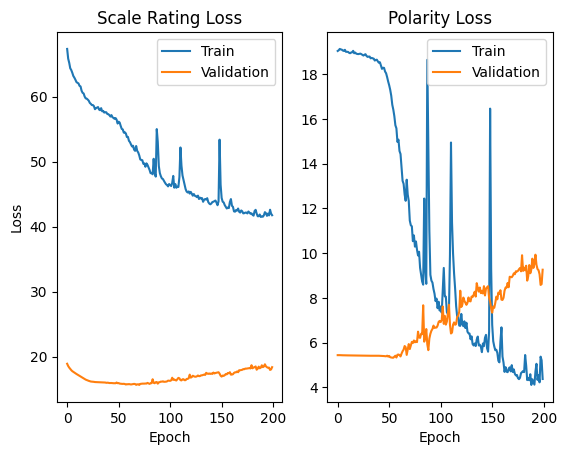

In [15]:
fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Scale Rating Loss')
axs[0].plot([i for i in range(n_epochs)], train_loss1,label='Train')
axs[0].plot([i for i in range(n_epochs)], val_loss1,label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].set_title('Polarity Loss')
axs[1].plot([i for i in range(n_epochs)], train_loss2,label='Train')
axs[1].plot([i for i in range(n_epochs)], val_loss2,label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.show()
plt.close()

Accuracy

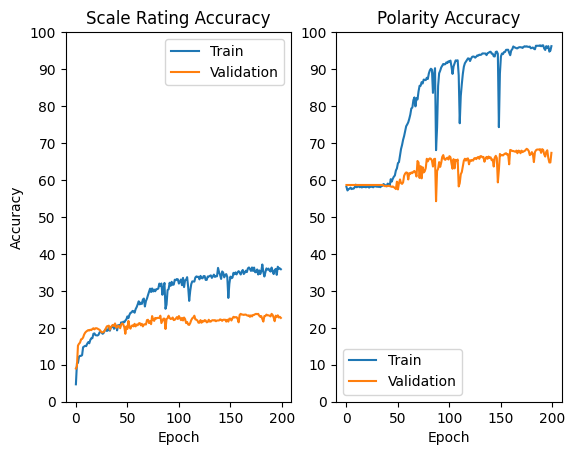

In [16]:
fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Scale Rating Accuracy')
axs[0].plot([i for i in range(n_epochs)], train_acc1, label='Train')
axs[0].plot([i for i in range(n_epochs)], val_acc1, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_yticks(np.arange(0,110,10))
axs[0].legend()
axs[1].set_title('Polarity Accuracy')
axs[1].plot([i for i in range(n_epochs)], train_acc2, label='Train')
axs[1].plot([i for i in range(n_epochs)], val_acc2, label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_yticks(np.arange(0,110,10))
axs[1].legend()
plt.show()
plt.close()

Get Validation Predictions

In [17]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for (text1, labels1), (text2, labels2) in zip(val_loader1, val_loader2):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        loss1 = criterion(pred1, labels1)
        # Predict auxiliary task (authorship of review)
        pred2 = model(text2, task_id = 1)
        loss2 = criterion(pred2, labels2)

        epoch_loss_val1 += loss1.item()
        epoch_loss_val2 += loss2.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)

        if i == 0:
            all_pred1 = pred1.cpu().detach().numpy()
            all_labels1 = labels1.cpu().detach().numpy()

            all_pred2 = pred2.cpu().detach().numpy()
            all_labels2 = labels2.cpu().detach().numpy()
            i += 1
        else:
            all_pred1 = np.concatenate([all_pred1, pred1.cpu().detach().numpy()])
            all_labels1 = np.concatenate([all_labels1, labels1.cpu().detach().numpy()])

            all_pred2 = np.concatenate([all_pred2, pred2.cpu().detach().numpy()])
            all_labels2 = np.concatenate([all_labels2, labels2.cpu().detach().numpy()])

        del text1, labels1, text2, labels2, pred1, pred2, loss1, loss2

Confusion Matrix

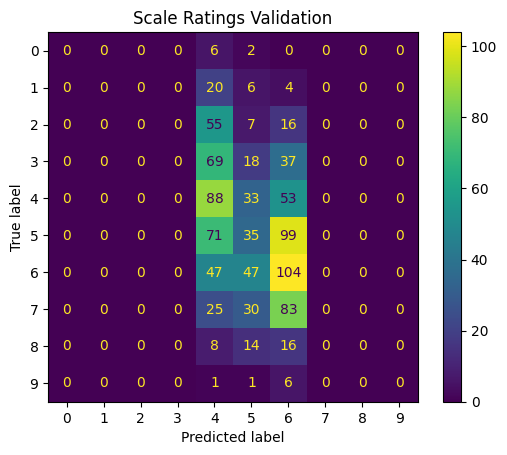

In [18]:
cm = confusion_matrix(all_labels1, all_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Scale Ratings Validation")
plt.show()

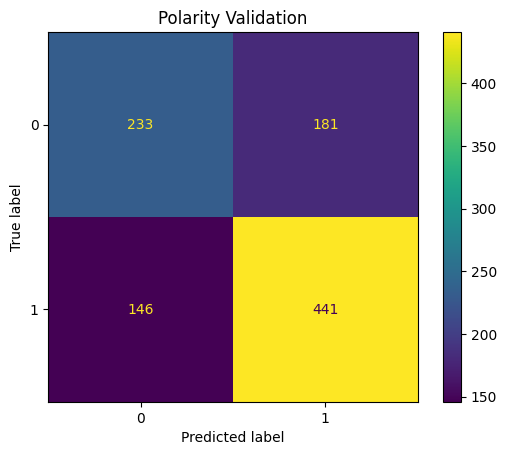

In [19]:
cm = confusion_matrix(all_labels2, all_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Polarity Validation")
plt.show()

In [20]:
f1 = f1_score(all_labels1, all_pred1, average = 'weighted')
f1_2 = f1_score(all_labels2, all_pred2, average = 'weighted')
print(f"F1 score for Scale Rating: {f1}")
print(f"F1 score for Polarity: {f1_2}")

F1 score for Scale Rating: 0.1570532383411368
F1 score for Polarity: 0.6708461371439852


## Get final test results

In [21]:
for i in range(test.shape[0]):
    review = test['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    test['Review'].iloc[i] = review

<ipython-input-21-a77be1b26ecf>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['Review'].iloc[i] = review
<ipython-input-21-a77be1b26ecf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [22]:
x_train, x_test, vocab = tokenize(train['Review'],test['Review'])

500 500


In [23]:
test_data1 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Rating'].values))
test_data2 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Polarity'].values))

test_loader1 = DataLoader(test_data1, shuffle=False, batch_size=batch_size)
test_loader2 = DataLoader(test_data2, shuffle=True, batch_size=batch_size)

In [25]:
# Validate
with torch.no_grad():
    model.eval()

    epoch_loss_test1=0
    epoch_loss_test2=0
    i=0
    for (text1, labels1), (text2, labels2) in zip(test_loader1, test_loader2):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        loss1 = criterion(pred1, labels1)
        # Predict auxiliary task (authorship of review)
        pred2 = model(text2, task_id = 1)
        loss2 = criterion(pred2, labels2)

        epoch_loss_test1 += loss1.item()
        epoch_loss_test2 += loss2.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)

        if i == 0:
            all_pred1 = pred1.cpu().detach().numpy()
            all_labels1 = labels1.cpu().detach().numpy()

            all_pred2 = pred2.cpu().detach().numpy()
            all_labels2 = labels2.cpu().detach().numpy()
            i += 1
        else:
            all_pred1 = np.concatenate([all_pred1, pred1.cpu().detach().numpy()])
            all_labels1 = np.concatenate([all_labels1, labels1.cpu().detach().numpy()])

            all_pred2 = np.concatenate([all_pred2, pred2.cpu().detach().numpy()])
            all_labels2 = np.concatenate([all_labels2, labels2.cpu().detach().numpy()])

        del text1, labels1, text2, labels2, pred1, pred2, loss1, loss2

Test confusion matrices

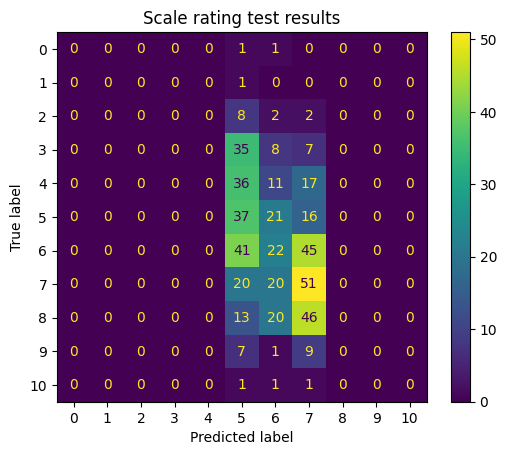

In [26]:
cm = confusion_matrix(all_labels1, all_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Scale rating test results")
plt.show()

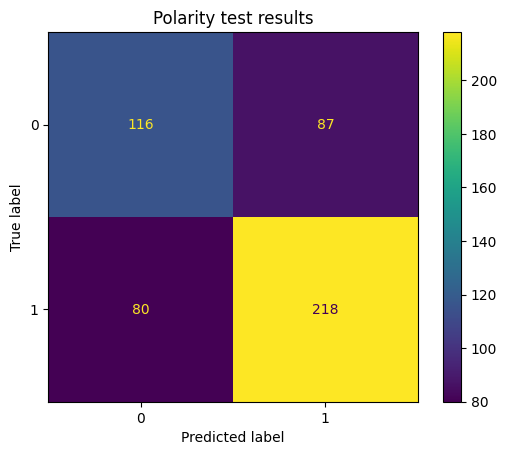

In [27]:
cm = confusion_matrix(all_labels2, all_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Polarity test results")
plt.show()

Test F1 score

In [28]:
f1 = f1_score(all_labels1, all_pred1, average = 'weighted')
f1_2 = f1_score(all_labels2, all_pred2, average = 'weighted')
print(f"F1 score for Scale Rating: {f1}")
print(f"F1 score for Polarity: {f1_2}")

F1 score for Scale Rating: 0.14901426765245698
F1 score for Polarity: 0.6656774606499666
